# SA2 Growth Model

## Purpose
Forecast quarterly median rents at SA2-level (2025–2030) using historical data and exogenous features (ERP, income). Compute future growth and CAGR for each suburb and identify high-growth SA2s.

## Inputs
- `historical_merged_df_all.csv` – Historical SA2-level median rents, ERP, income
- `full_erp_only_population_data.csv` – Annual ERP by SA2
- `income_predictions_2017_final.csv` – Predicted income by SA2 for 2025–2030

## Outputs
- `ucm_sa2_metrics.csv` / `ucm_sa2_predictions.csv` – UCM model evaluation and predictions
- `arima_new_sa2_metrics.csv` / `arima_new_sa2_predictions.csv` – ARIMA-new evaluation and predictions
- `sarimax_sa2.csv` – SARIMAX fitted and forecasted medians
- `growth_SARIMAX_SA2.csv` – Total growth and CAGR per SA2 (2025–2030)
- Plots of actual vs forecast for selected SA2s
- Top 10 SA2 growth bar charts

## Key Steps
1. Load and clean historical data; remove irrelevant features.
2. Aggregate and convert data to quarterly panels for modeling.
3. Define metrics calculation functions (MAE, RMSE, R²).
4. Train UCM models per SA2, evaluate, and store predictions.
5. Train ARIMA-new models per SA2 with exogenous features, evaluate, and store predictions.
6. Train SARIMAX models per SA2 for historical data; compare test vs forecast.
7. Prepare future ERP and income quarterly data for 2025–2030.
8. Forecast median rents for 2025–2030 using SARIMAX with exogenous data.
9. Compute total growth and CAGR per SA2; generate growth plots.
10. Save all outputs to clean directories for further analysis.


In [ ]:
import pandas as pd
import os
import warnings
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore")

In [80]:
# Load in the data that we will use to train our model
merged_df = pd.read_csv('../../datasets/raw/cleaned/curated/historical_merged_df_all.csv')

In [81]:
# The features that contributes the most are population and income, hence the features that are not in used will be dropped.
merged_df = merged_df.drop(columns=["CrimeRate_quarterly", "cultural", "education", "health", "others", "tourist"])

# UCM Model

In [82]:
# Configs
CSV_PATH = '../../datasets/raw/cleaned/curated/historical_merged_df_all.csv'
SPLIT = "2024-09-01"
EXOGS = ("ERP_quarterly", "Income_quarterly_med")
ENTITY_COL = "SA2_CODE21"
NAME_COL = "SA2_NAME21"
SEASONAL_PERIODS = 4
MIN_TRAIN = 8
MIN_TEST = 2

# Store all outputs in a clean folder
OUT_DIR = "../../datasets/results/modeling/ucm_sa2/"
os.makedirs(OUT_DIR, exist_ok=True)

OUT_METRICS = os.path.join(OUT_DIR, "ucm_sa2_metrics.csv")
OUT_PREDS = os.path.join(OUT_DIR, "ucm_sa2_predictions.csv")

### Helper function to calculate MAE, RMSE, and R² between actual and predicted values

In [83]:
def _metrics(y_true, y_pred):
    y_true = pd.to_numeric(pd.Series(y_true), errors="coerce")
    y_pred = pd.to_numeric(pd.Series(y_pred), errors="coerce")
    m = ~(y_true.isna() | y_pred.isna())
    if m.sum() == 0:
        return np.nan, np.nan, np.nan
    y_true = y_true[m]
    y_pred = y_pred[m]
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_true, y_pred) if len(y_true) > 1 else np.nan
    return mae, rmse, r2

def portfolio_np_summary(metrics_df, label):
    sub = metrics_df[['MAE_Test', 'RMSE_Test', 'R2_Test']].dropna(how='all')
    out = {
        'count': int(len(sub)),
        'MAE_mean': np.float64(sub['MAE_Test'].mean()) if not sub.empty else np.float64('nan'),
        'RMSE_mean': np.float64(sub['RMSE_Test'].mean()) if not sub.empty else np.float64('nan'),
        'R2_mean': np.float64(sub['R2_Test'].mean()) if not sub.empty else np.float64('nan'),
    }
    print(f"{label} : {out}")

### Load and prepare dataset

In [84]:
# Validate required columns
need_cols = {"date", "Median", ENTITY_COL, *EXOGS}
missing = [c for c in need_cols if c not in merged_df.columns]
if missing:
    raise KeyError(f"Input CSV missing required columns: {missing}")

name_map = None
if NAME_COL in merged_df.columns:
    tmp = merged_df[[ENTITY_COL, NAME_COL]].dropna().drop_duplicates(subset=[ENTITY_COL])
    name_map = tmp.set_index(ENTITY_COL)[NAME_COL]

In [85]:
# Aggregate Data by SA2 and Date  
agg_dict = {"Median": "median"}
for ex in EXOGS:
    agg_dict[ex] = "mean"

sa2_daily = (merged_df.dropna(subset=["date"]).groupby([ENTITY_COL, "date"], as_index=False).agg(agg_dict)
    .sort_values([ENTITY_COL, "date"]).reset_index(drop=True))

In [86]:
# Convert to Quarterly Panel Format
def to_quarterly_panel(df, entity_col=ENTITY_COL, exog_cols=EXOGS):
    need = [entity_col, "date", "Median", *exog_cols]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise KeyError(f"DataFrame missing columns: {missing}")

    out = df.copy()
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out = out.sort_values([entity_col, "date"]).reset_index(drop=True)

    def _qfill(g):
        g = g.set_index("date").asfreq("3MS").sort_index()
        for c in ["Median", *exog_cols]:
            g[c] = g[c].ffill().bfill()
        return g.reset_index()

    return (
        out.groupby(entity_col, group_keys=False)
        .apply(_qfill)
        .sort_values([entity_col, "date"])
        .reset_index(drop=True)
    )
    

### Fit UCM Model per SA2 Entity

In [87]:
def evaluate_ucm_per_entity(
    df,
    split_date=SPLIT,
    exog_cols=EXOGS,
    seasonal_periods=SEASONAL_PERIODS,
    min_train=MIN_TRAIN,
    min_test=MIN_TEST,
    entity_col=ENTITY_COL
):
    qdf = to_quarterly_panel(df, entity_col=entity_col, exog_cols=exog_cols)
    split_date = pd.Timestamp(split_date)

    metrics, preds = [], []
    for entity, g in qdf.groupby(entity_col):
        g = g[["date", "Median", *exog_cols]].copy()
        y = g.set_index("date")["Median"]
        X = g.set_index("date")[list(exog_cols)]

        y_tr, y_te = y[y.index < split_date], y[y.index >= split_date]
        X_tr, X_te = X.loc[y_tr.index], X.loc[y_te.index]

        if len(y_tr) < min_train or len(y_te) < min_test:
            continue

        try:
            mdl = UnobservedComponents(
                endog=y_tr,
                level="local linear trend",
                seasonal=seasonal_periods,
                exog=X_tr
            )
            res = mdl.fit(disp=False)
            fc = res.get_forecast(steps=len(y_te), exog=X_te)
            yhat = fc.predicted_mean

            mae, rmse, r2 = _metrics(y_te, yhat)
            metrics.append({
                entity_col: entity,
                "Model": f"UCM_LLtrend+Season{seasonal_periods}+exog",
                "MAE_Test": mae,
                "RMSE_Test": rmse,
                "R2_Test": r2,
                "Train_n": len(y_tr),
                "Test_n": len(y_te)
            })
            preds.append(pd.DataFrame({
                entity_col: entity,
                "date": y_te.index,
                "Actual": y_te.values,
                "Predicted": yhat.values,
                "Model": "UCM"
            }))
        except Exception as e:
            metrics.append({
                entity_col: entity,
                "Model": f"UCM_LLtrend+Season{seasonal_periods}+exog",
                "MAE_Test": np.nan,
                "RMSE_Test": np.nan,
                "R2_Test": np.nan,
                "Train_n": len(y_tr),
                "Test_n": len(y_te),
                "Error": str(e)
            })

    metrics_df = pd.DataFrame(metrics)
    preds_df = pd.concat(preds, ignore_index=True) if preds else pd.DataFrame()

    if name_map is not None and not metrics_df.empty:
        metrics_df[NAME_COL] = metrics_df[entity_col].map(name_map)
    if name_map is not None and not preds_df.empty:
        preds_df[NAME_COL] = preds_df[entity_col].map(name_map)

    return metrics_df, preds_df

### Run UCM Model 

In [88]:
ucm_metrics, ucm_preds = evaluate_ucm_per_entity(
    sa2_daily,
    split_date=SPLIT,
    exog_cols=EXOGS,
    seasonal_periods=SEASONAL_PERIODS,
    min_train=MIN_TRAIN,
    min_test=MIN_TEST,
    entity_col=ENTITY_COL
)

# Output summary
print(f"SA2s evaluated: {ucm_metrics[ENTITY_COL].nunique() if not ucm_metrics.empty else 0}")
print("Sample metrics:")
print(ucm_metrics.head(10).to_string(index=False))

print("\nSample predictions:")
print(ucm_preds.head(10).to_string(index=False))

# Save to CSV
ucm_metrics.to_csv(OUT_METRICS, index=False)
ucm_preds.to_csv(OUT_PREDS, index=False)

print(f"\nSaved metrics to: {OUT_METRICS}")
print(f"Saved predictions to: {OUT_PREDS}")

SA2s evaluated: 138
Sample metrics:
 SA2_CODE21                    Model  MAE_Test  RMSE_Test    R2_Test  Train_n  Test_n                    SA2_NAME21
  201011002 UCM_LLtrend+Season4+exog  7.316144   7.696208  -9.661690       30       3                      Ballarat
  201011005 UCM_LLtrend+Season4+exog 12.279051  12.816325  -4.317711       30       3                     Buninyong
  201011006 UCM_LLtrend+Season4+exog  6.764324   7.327018   0.000000       30       3                     Delacombe
  201011008 UCM_LLtrend+Season4+exog  7.065691   8.238537   0.000000       30       3       Wendouree - Miners Rest
  202011018 UCM_LLtrend+Season4+exog 11.649241  11.697597  -7.210027       30       3                       Bendigo
  202011021 UCM_LLtrend+Season4+exog  4.622510   4.708442   0.667459       30       3     Flora Hill - Spring Gully
  202011022 UCM_LLtrend+Season4+exog  9.190166   9.583807  -0.377740       30       3 Kangaroo Flat - Golden Square
  202021027 UCM_LLtrend+Season4+exog

In [89]:
# Get the test metrics
portfolio_np_summary(ucm_metrics, "UCM")

UCM : {'count': 138, 'MAE_mean': np.float64(17.008826541914228), 'RMSE_mean': np.float64(19.004376144500846), 'R2_mean': np.float64(-37.98002717344833)}


### Visualise UCM Forecasts for Sample SA2s

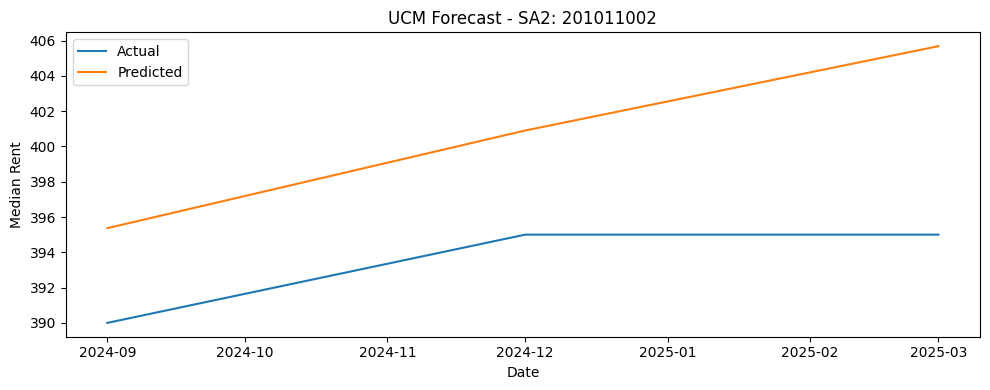

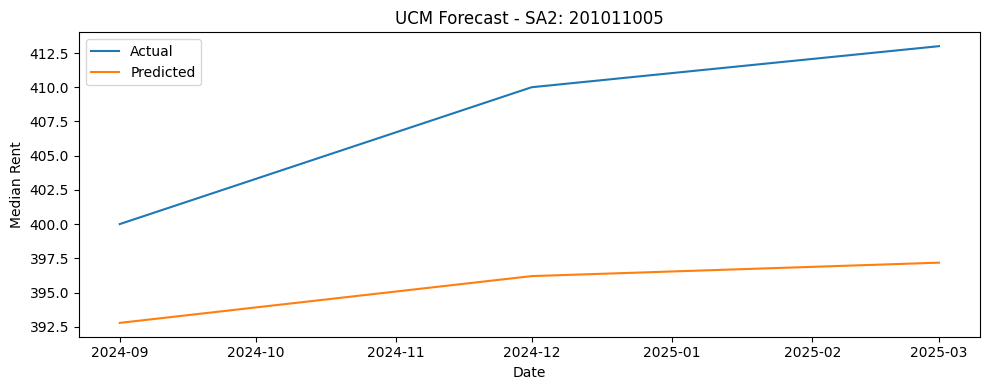

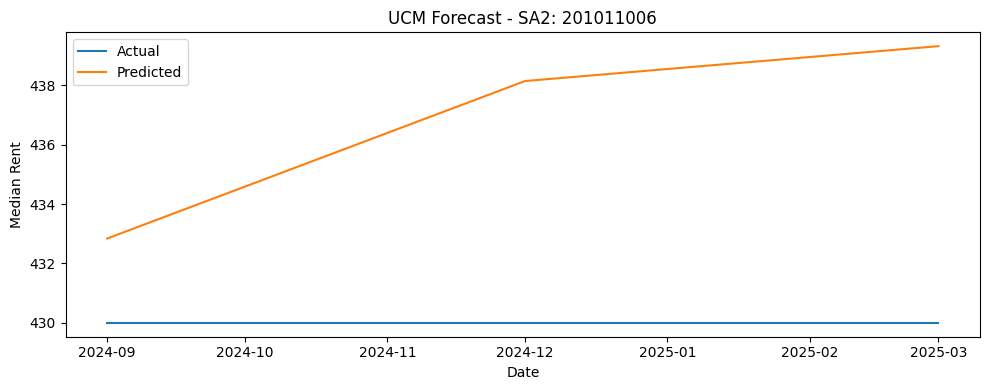

In [90]:
# first 3 available
example_sa2s = ucm_preds[ENTITY_COL].dropna().unique()[:3]  
for sa2 in example_sa2s:
    subset = ucm_preds[ucm_preds[ENTITY_COL] == sa2]
    plt.figure(figsize=(10, 4))
    plt.plot(subset['date'], subset['Actual'], label="Actual")
    plt.plot(subset['date'], subset['Predicted'], label="Predicted")
    plt.title(f"UCM Forecast - SA2: {sa2}")
    plt.xlabel("Date")
    plt.ylabel("Median Rent")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ARIMA Model 

In [91]:
# Configs
CSV_PATH = '../../datasets/raw/cleaned/curated/historical_merged_df_all.csv'
SPLIT = "2024-09-01"  

ENTITY_COL = "SA2_CODE21"
NAME_COL   = "SA2_NAME21"

BASE_EXOGS = ("ERP_quarterly", "Income_quarterly_med")
EXOGS = (*BASE_EXOGS, "ERPxIncome")  

P_GRID = (0, 1, 2, 3)
Q_GRID = (0, 1, 2, 3)

MIN_TRAIN = 12
MIN_TEST = 2
USE_LOG = True

# Store all outputs in a clean folder
OUT_DIR = "../../datasets/results/modeling/arima_sa2/"
os.makedirs(OUT_DIR, exist_ok=True)

OUT_METRICS = os.path.join(OUT_DIR, "arima_new_sa2_metrics.csv")
OUT_PREDS   = os.path.join(OUT_DIR, "arima_new_sa2_predictions.csv")

### Hyperparameter Tuning for ARIMA

In [92]:
def arima_new_best(y_tr, X_tr, p_grid=P_GRID, q_grid=Q_GRID):
    best = {"aic": np.inf, "order": None, "res": None}
    for p in p_grid:
        for q in q_grid:
            try:
                mdl = ARIMA(endog=y_tr, exog=X_tr, order=(p, 0, q))
                res = mdl.fit()
                if np.isfinite(res.aic) and res.aic < best["aic"]:
                    best = {"aic": res.aic, "order": (p, 0, q), "res": res}
            except Exception:
                continue
    return best

In [93]:
# Convert to Quarterly Panel
def to_quarterly_panel(df, entity_col=ENTITY_COL, base_exogs=BASE_EXOGS):
    need = [entity_col, "date", "Median", *base_exogs]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise KeyError(f"DataFrame missing columns: {missing}")

    out = df.copy()
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out = out.sort_values([entity_col, "date"]).reset_index(drop=True)

    def _qfill(g):
        g = g.set_index("date").asfreq("3MS").sort_index()
        for c in ["Median", *base_exogs]:
            g[c] = g[c].ffill().bfill()
        if set(base_exogs).issuperset({"ERP_quarterly", "Income_quarterly_med"}):
            g["ERPxIncome"] = g["ERP_quarterly"] * g["Income_quarterly_med"]
        else:
            ex = list(base_exogs)
            g["ERPxIncome"] = g[ex[0]] * g[ex[1]] if len(ex) >= 2 else np.nan
        return g.reset_index()

    return (
        out.groupby(entity_col, group_keys=False)
           .apply(_qfill)
           .sort_values([entity_col, "date"])
           .reset_index(drop=True)
    )

### Evaluate ARIMA Models for Each SA2

In [94]:
def evaluate_arima_new_sa2(
    df,
    split_date=SPLIT,
    entity_col=ENTITY_COL,
    exog_cols=EXOGS,
    base_exogs=BASE_EXOGS,
    p_grid=P_GRID,
    q_grid=Q_GRID,
    min_train=MIN_TRAIN,
    min_test=MIN_TEST,
    use_log=USE_LOG
):
    qdf = to_quarterly_panel(df, entity_col=entity_col, base_exogs=base_exogs)
    split_date = pd.Timestamp(split_date)

    metrics, preds = [], []

    for sa2, g in qdf.groupby(entity_col):
        g = g[["date", "Median", *exog_cols]].copy().set_index("date").sort_index()
        g = g.ffill().bfill()

        y = g["Median"]
        X = g[list(exog_cols)]

        y_tr, y_te = y[y.index < split_date], y[y.index >= split_date]
        X_tr, X_te = X.loc[y_tr.index], X.loc[y_te.index]

        if len(y_tr) < min_train or len(y_te) < min_test:
            continue

        try:
            y_tr_fit = np.log(y_tr.clip(lower=1.0)) if use_log else y_tr
            best = arima_new_best(y_tr_fit, X_tr, p_grid=p_grid, q_grid=q_grid)

            if best["res"] is None:
                raise RuntimeError("No converged ARIMA-new model for this SA2.")

            fc = best["res"].forecast(steps=len(y_te), exog=X_te)
            yhat_log_or_lin = pd.Series(fc, index=y_te.index)
            yhat = np.exp(yhat_log_or_lin.values) if use_log else yhat_log_or_lin.values

            mae, rmse, r2 = _metrics(y_te, yhat)

            metrics.append({
                entity_col: sa2,
                "Model": "ARIMA-new",
                "MAE_Test": mae,
                "RMSE_Test": rmse,
                "R2_Test": r2,
                "Train_n": len(y_tr),
                "Test_n": len(y_te),
                "AIC": best["aic"],
                "Order": best["order"]
            })

            preds.append(pd.DataFrame({
                entity_col: sa2,
                "date": y_te.index,
                "Actual": y_te.values,
                "Predicted": yhat,
                "Model": "ARIMA-new"
            }))

        except Exception as e:
            metrics.append({
                entity_col: sa2,
                "Model": "ARIMA-new",
                "MAE_Test": np.nan,
                "RMSE_Test": np.nan,
                "R2_Test": np.nan,
                "Train_n": len(y_tr),
                "Test_n": len(y_te),
                "AIC": np.inf,
                "Error": str(e)
            })

    metrics_df = pd.DataFrame(metrics)
    preds_df = pd.concat(preds, ignore_index=True) if preds else pd.DataFrame()

    if name_map is not None and not metrics_df.empty:
        metrics_df[NAME_COL] = metrics_df[entity_col].map(name_map)
    if name_map is not None and not preds_df.empty:
        preds_df[NAME_COL] = preds_df[entity_col].map(name_map)

    return metrics_df, preds_df


### Run ARIMA Model 

In [95]:
arima_metrics, arima_preds = evaluate_arima_new_sa2(
    sa2_daily,
    split_date=SPLIT,
    entity_col=ENTITY_COL,
    exog_cols=EXOGS,
    base_exogs=BASE_EXOGS,
    p_grid=P_GRID,
    q_grid=Q_GRID,
    min_train=MIN_TRAIN,
    min_test=MIN_TEST,
    use_log=USE_LOG
)

print(f"SA2s evaluated: {arima_metrics[ENTITY_COL].nunique() if not arima_metrics.empty else 0}")
print("Sample metrics:\n", arima_metrics.head(10).to_string(index=False))
print("\nSample predictions:\n", arima_preds.head(10).to_string(index=False))

arima_metrics.to_csv(OUT_METRICS, index=False)
arima_preds.to_csv(OUT_PREDS, index=False)

print(f"\nSaved metrics to: {OUT_METRICS}")
print(f"Saved predictions to: {OUT_PREDS}")

SA2s evaluated: 138
Sample metrics:
  SA2_CODE21     Model  MAE_Test  RMSE_Test     R2_Test  Train_n  Test_n         AIC     Order                    SA2_NAME21
  201011002 ARIMA-new  7.406074   8.232607  -11.199646       30       3 -166.201138 (2, 0, 2)                      Ballarat
  201011005 ARIMA-new 16.123495  17.175739   -8.550554       30       3 -156.109233 (1, 0, 0)                     Buninyong
  201011006 ARIMA-new  9.619885  10.113367    0.000000       30       3 -167.785904 (1, 0, 0)                     Delacombe
  201011008 ARIMA-new  3.896449   4.342046    0.000000       30       3 -187.249438 (2, 0, 3)       Wendouree - Miners Rest
  202011018 ARIMA-new 30.121509  30.812116  -55.963189       30       3 -190.482281 (1, 0, 0)                       Bendigo
  202011021 ARIMA-new 15.915080  20.109218   -5.065710       30       3 -160.331099 (1, 0, 1)     Flora Hill - Spring Gully
  202011022 ARIMA-new  5.868950   6.703180    0.326011       30       3 -167.692014 (2, 0, 1) K

### Visualise ARIMA Forecasts for Sample SA2s

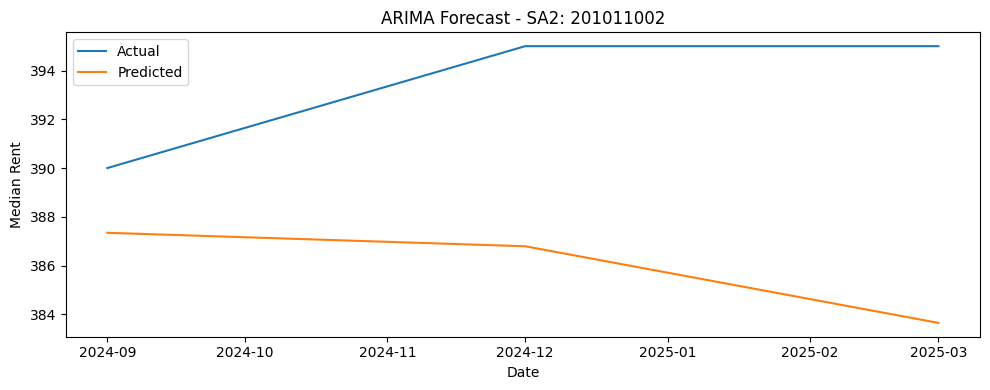

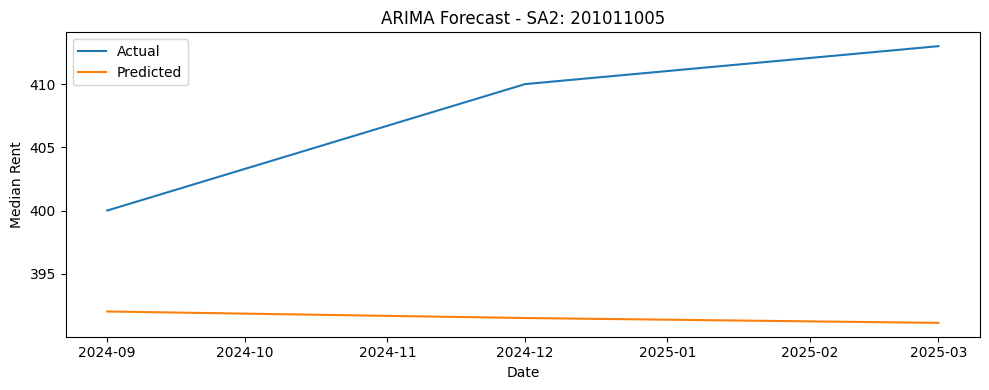

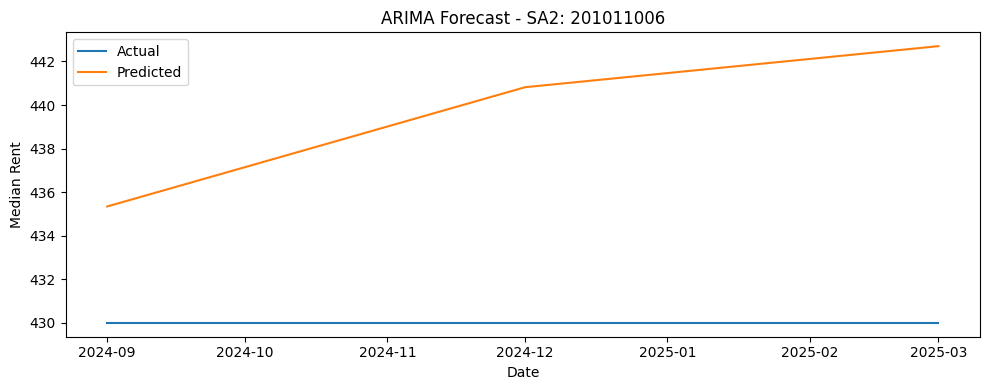

In [96]:
example_sa2s = arima_preds[ENTITY_COL].dropna().unique()[:3]
for sa2 in example_sa2s:
    subset = arima_preds[arima_preds[ENTITY_COL] == sa2]
    plt.figure(figsize=(10, 4))
    plt.plot(subset['date'], subset['Actual'], label="Actual")
    plt.plot(subset['date'], subset['Predicted'], label="Predicted")
    plt.title(f"ARIMA Forecast - SA2: {sa2}")
    plt.xlabel("Date")
    plt.ylabel("Median Rent")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [97]:
# Get the test metrics
portfolio_np_summary(arima_metrics, "ARIMA-new")

ARIMA-new : {'count': 138, 'MAE_mean': np.float64(26.25318928262348), 'RMSE_mean': np.float64(28.64666969983798), 'R2_mean': np.float64(-91.66172725588173)}


# Sarimax model (final model)

In [98]:
merged_df

,Suburb,date,Median,Lat,Lng,SA2_CODE21,SA2_NAME21,ERP_quarterly,Income_quarterly_med
0,Albert Park-Middle Park-West St Kilda,2017-03-01,520,-37.853484,144.970161,206051128,Albert Park,16536.854795,62618.808219
1,Albert Park-Middle Park-West St Kilda,2017-06-01,532,-37.853484,144.970161,206051128,Albert Park,16594.323288,62804.068493
2,Albert Park-Middle Park-West St Kilda,2017-09-01,530,-37.853484,144.970161,206051128,Albert Park,16651.791781,62989.328767
3,Albert Park-Middle Park-West St Kilda,2017-12-01,530,-37.853484,144.970161,206051128,Albert Park,16708.635616,63172.575342
4,Albert Park-Middle Park-West St Kilda,2018-03-01,550,-37.853484,144.970161,206051128,Albert Park,16785.060274,63400.523288
...,...,...,...,...,...,...,...,...,...
4813,Yarraville-Seddon,2024-03-01,570,-37.812809,144.884163,213031352,Yarraville,16280.121038,84590.600000
4814,Yarraville-Seddon,2024-06-01,590,-37.812809,144.884163,213031352,Yarraville,16337.039963,84590.600000
4815,Yarraville-Seddon,2024-09-01,595,-37.812809,144.884163,213031352,Yarraville,16393.958888,84590.600000
4816,Yarraville-Seddon,2024-12-01,600,-37.812809,144.884163,213031352,Yarraville,16450.259129,84590.600000


Train and evaluate

In [99]:
def compare_plot_suburb_test(
    merged_df,
    SA2_CODE21,
    split_date="2024-09-01",
    exog_cols=("ERP_quarterly", "Income_quarterly_med"),
    order=(1,1,0),
    figsize=(10,5), 
    ci_alpha=0.2
):
    """
    Fit SARIMAX(endog=Median, exog=exog_cols) on TRAIN (< split_date),
    forecast TEST (>= split_date), return comparison DF and plot
    test actual vs test forecast with 95% CI.

    Returns: comparison DataFrame with columns:
        ['SA2_CODE21','date','Actual','Predicted','Error','AbsError','PctError']
    """

    # Take only SA2_CODE21 adjust to quarterly freq 
    g = merged_df.loc[merged_df["SA2_CODE21"] == SA2_CODE21,
                      ["date","Median"] + list(exog_cols)].copy()
    if g.empty:
        print(f"No rows for SA2_CODE21: {SA2_CODE21}")
        return pd.DataFrame()

    g["date"] = pd.to_datetime(g["date"])
    g = (
        g.drop_duplicates(subset=["date"])
         .set_index("date")
         .asfreq("3MS")
         .sort_index()
    )

    # endog/exog
    missing = [c for c in exog_cols if c not in g.columns]
    if missing:
        print(f"Missing exog columns for {SA2_CODE21}: {missing}")
        return pd.DataFrame()

    y = g["Median"].ffill().bfill()
    X = g[list(exog_cols)].ffill().bfill()

    # Spilt train and test
    split_date = pd.Timestamp(split_date)
    y_train, y_test = y.loc[y.index < split_date],  y.loc[y.index >= split_date]
    X_train, X_test = X.loc[X.index < split_date],  X.loc[X.index >= split_date]

    if len(y_test) == 0:
        print(f"No test rows for {SA2_CODE21} on/after {split_date.date()}.")
        return pd.DataFrame()

    # Train to model
    mdl = sm.tsa.SARIMAX(
        endog=y_train, exog=X_train,
        order=order, seasonal_order=(0,0,0,0),
        trend="c", enforce_stationarity=False, enforce_invertibility=False
    )
    fit = mdl.fit(method="lbfgs", disp=False, maxiter=1000)

    # TRAIN metrics 
    y_pred_train = fit.fittedvalues
    mae_train  = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train   = r2_score(y_train, y_pred_train) if len(y_train) > 1 else np.nan

    # TEST forecast 
    fc = fit.get_forecast(steps=len(y_test), exog=X_test)
    y_pred = pd.Series(fc.predicted_mean.values, index=y_test.index)
    ci = fc.conf_int(alpha=0.05)  # 95% CI
    ci.index = y_test.index

    # TEST metrics 
    mae_test  = mean_absolute_error(y_test, y_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_test   = r2_score(y_test, y_pred) if len(y_test) > 1 else np.nan

    # Comparison table 
    cmp = pd.DataFrame({
        "SA2_CODE21": SA2_CODE21,
        "date": y_test.index,
        "Actual": y_test.values,
        "Predicted": y_pred.values
    })
    cmp["Error"]    = cmp["Predicted"] - cmp["Actual"]
    cmp["AbsError"] = cmp["Error"].abs()
    cmp["PctError"] = np.where(cmp["Actual"] != 0, cmp["Error"] / cmp["Actual"], np.nan)
 
    # Plot test actual vs forecast
    plt.figure(figsize=figsize)
    plt.plot(y_test.index, y_test.values, label="Test (actual)", lw=1.8)
    plt.plot(y_pred.index, y_pred.values, label="Forecast", lw=2, linestyle="--")
    plt.fill_between(y_pred.index, ci.iloc[:,0], ci.iloc[:,1], alpha=ci_alpha, label="95% CI")
    plt.title(f"{SA2_CODE21} — SARIMAX{order} | Test actual vs forecast")
    plt.xlabel("Quarter")
    plt.ylabel("Median rent")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return both the table and metrics
    return cmp, {
        "Train_MAE": mae_train,
        "Train_RMSE": rmse_train,
        "Train_R2": r2_train,
        "Test_MAE": mae_test,
        "Test_RMSE": rmse_test,
        "Test_R2": r2_test
    }

In [ ]:
all_metrics = []  
all_preds = []  

# Loop over every SA2_CODE21
for sa2 in sorted(merged_df["SA2_CODE21"].unique()):
    cmp_df, metrics = compare_plot_suburb_test(
        merged_df,
        SA2_CODE21=sa2,
        split_date="2024-09-01",
        exog_cols=("ERP_quarterly","Income_quarterly_med"),
        order=(1,1,0)
    )

    # attach SA2_CODE21 name and metrics
    metrics["SA2_CODE21"] = sa2
    all_metrics.append(metrics)

    #Store predictions if not empty
    if not cmp_df.empty:
        all_preds.append(cmp_df)

# combine all SA2_CODE21 metrics into one DataFrame
metrics_df = pd.DataFrame(all_metrics)

# combine all predictions
preds_df_sarimax = pd.concat(all_preds, ignore_index=True) if all_preds else pd.DataFrame()

# Print overall averages
print("\n Averages Across All SA2")
print(f"Avg Train RMSE: {metrics_df['Train_RMSE'].mean():.2f}")
print(f"Avg Test  RMSE: {metrics_df['Test_RMSE'].mean():.2f}")
print(f"Avg Train R²: {metrics_df['Train_R2'].mean():.3f}")
print(f"Avg Test  R²: {metrics_df['Test_R2'].mean():.3f}")

# Show top 10 SA2 with best test RMSE
print("\nTop 10 SA2 by Test RMSE:")
print(metrics_df.sort_values("Test_RMSE", ascending=True).tail(10)[
    ["SA2_CODE21", "Train_RMSE", "Test_RMSE", "Train_R2", "Test_R2"]
])

In [101]:
# RMSE of Brighton which is the worst is 56.986680
rmse = 56.986680
mean_price = merged_df["Median"].mean()  

relative_rmse = (rmse / mean_price) * 100
print(f"Relative RMSE Brighton: {relative_rmse:.2f}%")

# RMSE of Broadmeadows-Roxburgh Park which is the worst is 56.986680
rmse = 1.847763 
mean_price = merged_df["Median"].mean()  

relative_rmse = (rmse / mean_price) * 100
print(f"Relative RMSE Broadmeadows: {relative_rmse:.2f}%")


Relative RMSE Brighton: 12.93%
Relative RMSE Broadmeadows: 0.42%


In [102]:
preds_df_sarimax

,SA2_CODE21,date,Actual,Predicted,Error,AbsError,PctError
0,201011002,2024-09-01,390,391.850913,1.850913,1.850913,0.004746
1,201011002,2024-12-01,395,396.537195,1.537195,1.537195,0.003892
2,201011002,2025-03-01,395,400.259286,5.259286,5.259286,0.013315
3,201011005,2024-09-01,400,395.922184,-4.077816,4.077816,-0.010195
4,201011005,2024-12-01,410,398.871576,-11.128424,11.128424,-0.027142
...,...,...,...,...,...,...,...
409,217011422,2024-12-01,400,408.398559,8.398559,8.398559,0.020996
410,217011422,2025-03-01,400,413.623082,13.623082,13.623082,0.034058
411,217041479,2024-09-01,480,482.719599,2.719599,2.719599,0.005666
412,217041479,2024-12-01,480,491.293073,11.293073,11.293073,0.023527


In [103]:
preds_df_sarimax.to_csv("../../datasets/results/modeling/sarimax_sa2.csv",index=False)

# Prepare Projected Features to use for forecasting

In [104]:
# Load/Copy data needed
population_df = pd.read_csv('../../datasets/raw/cleaned/curated/full_erp_only_population_data.csv')
income_df = pd.read_csv("../../datasets/income/income_predictions_2017_final.csv")
future_data = merged_df.copy()

In [105]:
future_data = future_data.drop(columns=["ERP_quarterly", "Income_quarterly_med"])
future_data.head()

,Suburb,date,Median,Lat,Lng,SA2_CODE21,SA2_NAME21
0,Albert Park-Middle Park-West St Kilda,2017-03-01,520,-37.853484,144.970161,206051128,Albert Park
1,Albert Park-Middle Park-West St Kilda,2017-06-01,532,-37.853484,144.970161,206051128,Albert Park
2,Albert Park-Middle Park-West St Kilda,2017-09-01,530,-37.853484,144.970161,206051128,Albert Park
3,Albert Park-Middle Park-West St Kilda,2017-12-01,530,-37.853484,144.970161,206051128,Albert Park
4,Albert Park-Middle Park-West St Kilda,2018-03-01,550,-37.853484,144.970161,206051128,Albert Park


### Future ERP Quarterly

In [106]:
# Long-form annual ERP with a proper date
erp_quarterly = (population_df.melt(id_vars='sa2_code', var_name='year', value_name='ERP').assign(year=lambda x: x['year'].str.extract(r'(\d{4})').astype(int),
          ERP=lambda x: pd.to_numeric(x['ERP'], errors='coerce'), date=lambda x: pd.to_datetime(x['year'].astype(str) + '-01-01')).groupby(['sa2_code','date'], as_index=False)['ERP'].mean())

# Target quarterly index, Start predict from June
q_idx = pd.date_range('2025-06-01', '2030-12-01', freq='QS-MAR')

# For each SA2: union with quarterly timeline, interpolate by time, then keep quarters
frames = []
for sa2, g in erp_quarterly.groupby('sa2_code', sort=False):
    g = (g.set_index('date').sort_index())

    # build a union index so interpolate
    full_idx = g.index.union(q_idx).unique().sort_values()

    # reindex to union, then time-based interpolation
    gg = (g.reindex(full_idx).interpolate(method='time', limit_direction='both'))

    # keep only the quarterly stamps we want
    gg = gg.reindex(q_idx)

    gg['sa2_code'] = sa2
    frames.append(gg)

erp_future_quarterly = (pd.concat(frames, axis=0).reset_index().rename(columns={'index': 'date'}).loc[:, ['sa2_code', 'date', 'ERP']])

# Build a unique lookup for Suburb per SA2
suburb_lookup = (future_data[["SA2_CODE21", "Suburb"]].dropna(subset=["SA2_CODE21", "Suburb"]).drop_duplicates(subset=["SA2_CODE21"]).rename(columns={"SA2_CODE21": "sa2_code"}))

# Merge Suburb onto ERP quarterly data
erp_future_quarterly = erp_future_quarterly.merge(suburb_lookup, how="right", on="sa2_code")

# Reorder columns 
erp_future_quarterly = erp_future_quarterly[["sa2_code", "Suburb", "date", "ERP"]]
erp_future_quarterly = erp_future_quarterly.rename(columns={'sa2_code': 'SA2_CODE21'})
erp_future_quarterly.tail(10)

,SA2_CODE21,Suburb,date,ERP
3164,213031352,Yarraville-Seddon,2028-09-01,17120.896274
3165,213031352,Yarraville-Seddon,2028-12-01,17160.524127
3166,213031352,Yarraville-Seddon,2029-03-01,17199.786900
3167,213031352,Yarraville-Seddon,2029-06-01,17239.959987
3168,213031352,Yarraville-Seddon,2029-09-01,17280.133073
3169,213031352,Yarraville-Seddon,2029-12-01,17319.869496
3170,213031352,Yarraville-Seddon,2030-03-01,17359.169254
3171,213031352,Yarraville-Seddon,2030-06-01,17399.342340
3172,213031352,Yarraville-Seddon,2030-09-01,17439.515427
3173,213031352,Yarraville-Seddon,2030-12-01,17479.251849


### Future Income Quarterly

In [107]:
income_df = pd.read_csv("../../datasets/income/income_predictions_2017_final.csv")

# First row is victoria we dont need it
income_df = income_df.drop(income_df.index[0]).reset_index(drop=True)
income_df = income_df.rename(columns={"SA2": "sa2_code"})

In [108]:
# Ensure sa2_code is integer 
income_df['sa2_code'] = pd.to_numeric(income_df['sa2_code'], errors='coerce').astype('Int64')

# Normalise suburb name column to 'sa2_name'
if 'sa2_name' in income_df.columns:
    pass
elif 'SA2 NAME' in income_df.columns:
    income_df = income_df.rename(columns={'SA2 NAME': 'sa2_name'})
else:
    income_df['sa2_name'] = pd.NA

# Pick predicted columns (2025–2030)
income_year_cols = [c for c in income_df.columns if re.fullmatch(r'Predicted_Income_\d{4}', c)]
if not income_year_cols:
    raise ValueError("No columns matching 'Predicted_Income_YYYY' found.")

# Reshape to long format with clean year/date
income_long = (income_df[['sa2_code', 'sa2_name'] + income_year_cols].melt(id_vars=['sa2_code','sa2_name'], var_name='year_col', value_name='Predicted_Income')
               .assign(year=lambda x: x['year_col'].str.extract(r'(\d{4})').astype(int), Predicted_Income=lambda x: pd.to_numeric(x['Predicted_Income'], errors='coerce'), date=lambda x: pd.to_datetime(x['year'].astype(str) + '-01-01')).groupby(['sa2_code','sa2_name','date'], as_index=False)['Predicted_Income'].mean())

# Quarterly date index from 2025 → 2030
q_idx = pd.date_range('2025-06-01', '2030-12-01', freq='QS-MAR')

# Interpolate + extrapolate quarterly
frames = []
for (sa2, name), g in income_long.groupby(['sa2_code','sa2_name'], sort=False):
    g = g.set_index('date').sort_index()
    g = g.infer_objects(copy=False)
    g['Predicted_Income'] = pd.to_numeric(g['Predicted_Income'], errors='coerce')

    full_idx = g.index.union(q_idx).unique().sort_values()

    gg = g.reindex(full_idx)
    gg = gg.infer_objects(copy=False) 
    gg['Predicted_Income'] = pd.to_numeric(gg['Predicted_Income'], errors='coerce')
    gg = gg.interpolate(method='time', limit_direction='both')


    gg = gg.reindex(q_idx)
    gg['sa2_code'] = sa2
    gg['sa2_name'] = name
    frames.append(gg)

# Combine all SA2 results
income_future_quarterly = (pd.concat(frames, axis=0).reset_index().rename(columns={'index': 'date'}).loc[:, ['sa2_code', 'sa2_name', 'date', 'Predicted_Income']])

# Ensure types same
income_future_quarterly['sa2_code'] = income_future_quarterly['sa2_code'].astype(int)

print(income_future_quarterly.head())
income_future_quarterly = income_future_quarterly.rename(columns={'sa2_code': 'SA2_CODE21'})
income_future_quarterly = income_future_quarterly.rename(columns={'sa2_name': 'SA2_NAME21'})

    sa2_code   sa2_name       date  Predicted_Income
0  201011001  Alfredton 2025-06-01      63004.510055
1  201011001  Alfredton 2025-09-01      63428.473421
2  201011001  Alfredton 2025-12-01      63847.828489
3  201011001  Alfredton 2026-03-01      64262.575261
4  201011001  Alfredton 2026-06-01      64686.538629


In [109]:
erp_income_future = erp_future_quarterly.merge(income_future_quarterly,on=["SA2_CODE21", "date"],how="inner")
 
prediction_df = future_data.merge(
    erp_income_future,
    on=["SA2_CODE21","SA2_NAME21"],
    how="left"
)
prediction_df = prediction_df.drop(columns=["t", "date_x","Median","Suburb_x"], errors="ignore")
prediction_df = prediction_df.rename(columns={'date_y': 'date' , 'Suburb_y' : 'Suburb'})
prediction_df.head()

,Lat,Lng,SA2_CODE21,SA2_NAME21,Suburb,date,ERP,Predicted_Income
0,-37.853484,144.970161,206051128,Albert Park,Albert Park-Middle Park-West St Kilda,2025-06-01,17081.458844,80479.028754
1,-37.853484,144.970161,206051128,Albert Park,Albert Park-Middle Park-West St Kilda,2025-09-01,17063.176312,81070.846211
2,-37.853484,144.970161,206051128,Albert Park,Albert Park-Middle Park-West St Kilda,2025-12-01,17045.092504,81656.230868
3,-37.853484,144.970161,206051128,Albert Park,Albert Park-Middle Park-West St Kilda,2026-03-01,17068.777750,82235.182728
4,-37.853484,144.970161,206051128,Albert Park,Albert Park-Middle Park-West St Kilda,2026-06-01,17115.316752,82827.000184


### Retrain SARIMAX on full dataset and forecast future rents

In [110]:
# Remove duplicate combinations
merged_df = merged_df.drop_duplicates(subset=["SA2_CODE21", "date"])
prediction_df = prediction_df.drop_duplicates(subset=["SA2_CODE21", "date"])

print("Duplicates removed. Shapes now:")
print("merged_df:", merged_df.shape)
print("prediction_df:", prediction_df.shape)

Duplicates removed. Shapes now:
merged_df: (4554, 9)
prediction_df: (3174, 8)


In [111]:
def forecast_future_medians(merged_df, prediction_df, exog_cols=("ERP_quarterly", "Income_quarterly_med"),
    order=(1,1,0), start_future="2025-06-01", end_future="2030-12-01"):
    """
    For each SA2_CODE21:
      1. Fit SARIMAX on full history (merged_df)
      2. Forecast medians for 2025-06 → 2030-12 using exogenous values from prediction_df
    Returns a single DataFrame with predicted medians.
    """

    start_future = pd.Timestamp(start_future)
    end_future   = pd.Timestamp(end_future)

    all_forecasts = []

    for SA2_CODE21 in tqdm(merged_df["SA2_CODE21"].unique(), desc="Forecasting future medians"):
        # Historical data for training
        g_hist = merged_df.loc[
            merged_df["SA2_CODE21"] == SA2_CODE21,
            ["date", "Median"] + list(exog_cols)
        ].copy()

        if g_hist.empty:
            continue

        g_hist["date"] = pd.to_datetime(g_hist["date"])
        g_hist = g_hist.set_index("date").asfreq("3MS").sort_index()

        y = g_hist["Median"].ffill().bfill()
        X = g_hist[list(exog_cols)].ffill().bfill()

        # Future exogenous data
        g_future = prediction_df.loc[prediction_df["SA2_CODE21"] == SA2_CODE21].copy()
        if g_future.empty:
            continue

        g_future["date"] = pd.to_datetime(g_future["date"])
        g_future = g_future.set_index("date").sort_index()

        # Restrict to requested forecast horizon
        g_future = g_future.loc[(g_future.index >= start_future) & (g_future.index <= end_future)]
        if g_future.empty:
            continue

        X_future = g_future[list(exog_cols)].ffill().bfill()

        # Fit SARIMAX model on full data 
        mdl = sm.tsa.SARIMAX(
            endog=y,
            exog=X,
            order=order,
            seasonal_order=(0,0,0,0),
            trend="c",
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fit = mdl.fit(method="lbfgs", disp=False, maxiter=1000)

        # Forecast 
        fc = fit.get_forecast(steps=len(X_future), exog=X_future)
        y_pred = pd.Series(fc.predicted_mean.values, index=X_future.index)

        # Store results 
        df_out = g_future.reset_index()[["date"]].copy()
        df_out["SA2_CODE21"] = SA2_CODE21
        df_out["Predicted_Median"] = y_pred.values
        df_out["Model"] = f"SARIMAX{order}"
        all_forecasts.append(df_out)

    forecast_df = pd.concat(all_forecasts, ignore_index=True) if all_forecasts else pd.DataFrame()
    return forecast_df


In [112]:
rename_map = {
    "Predicted_Income": "Income_quarterly_med",
    "ERP": "ERP_quarterly"
}

prediction_df = prediction_df.rename(columns=rename_map)
future_forecasts = forecast_future_medians(
    merged_df=merged_df,
    prediction_df=prediction_df,
    exog_cols=("ERP_quarterly", "Income_quarterly_med"),
    order=(1,1,0),
    start_future="2025-06-01",
    end_future="2030-12-01"
)

print(f"Forecast complete: {future_forecasts.shape[0]} rows")
print(future_forecasts.head())


Forecasting future medians:   0%|          | 0/138 [00:00<?, ?it/s]

Forecasting future medians: 100%|██████████| 138/138 [00:03<00:00, 44.15it/s]

Forecast complete: 3174 rows
        date  SA2_CODE21  Predicted_Median             Model
0 2025-06-01   206051128        659.934693  SARIMAX(1, 1, 0)
1 2025-09-01   206051128        662.200969  SARIMAX(1, 1, 0)
2 2025-12-01   206051128        664.593196  SARIMAX(1, 1, 0)
3 2026-03-01   206051128        668.454089  SARIMAX(1, 1, 0)
4 2026-06-01   206051128        672.864073  SARIMAX(1, 1, 0)


In [113]:
def compute_growth_2025_to_2030(merged_df, future_forecasts):
    """
    Computes total percentage growth and CAGR (2025-03 → 2030-12) for each suburb.
    Saves result as global variable growth_df.
    """

    global growth_df 

    # Ensure datetime
    merged_df["date"] = pd.to_datetime(merged_df["date"], errors="coerce")
    future_forecasts["date"] = pd.to_datetime(future_forecasts["date"], errors="coerce")

    # Define start and end
    base_date = pd.Timestamp("2025-03-01")
    end_date  = pd.Timestamp("2030-12-01")
    n_years = (end_date.year + (end_date.month - 1)/12) - (base_date.year + (base_date.month - 1)/12)

    # Last Actual date
    base_df = (
        merged_df.loc[merged_df["date"] == base_date, ["SA2_CODE21", "Median"]]
        .rename(columns={"Median": "Median_2025Q1"})
    )

    # Last Future date
    future_df = (
        future_forecasts.loc[future_forecasts["date"] == end_date, ["SA2_CODE21", "Predicted_Median"]]
        .rename(columns={"Predicted_Median": "Median_2030Q4"})
    )

    # Merge + compute growth
    growth_df = pd.merge(base_df, future_df, on="SA2_CODE21", how="inner")
    growth_df["Total_Growth_%"] = (
        (growth_df["Median_2030Q4"] - growth_df["Median_2025Q1"]) / growth_df["Median_2025Q1"] * 100
    )

    # CAGR
    growth_df["CAGR_%"] = (
        ((growth_df["Median_2030Q4"] / growth_df["Median_2025Q1"]) ** (1 / n_years) - 1) * 100
    )

    # Sort descending by CAGR
    growth_df = growth_df.sort_values("CAGR_%", ascending=False).reset_index(drop=True)

    print(f"Computed total growth and CAGR for {len(growth_df)} suburbs (2025-03 → 2030-12).")
    print(growth_df.head(10))

    return growth_df

In [114]:
growth_results = compute_growth_2025_to_2030(merged_df, future_forecasts)

Computed total growth and CAGR for 138 suburbs (2025-03 → 2030-12).
   SA2_CODE21  Median_2025Q1  Median_2030Q4  Total_Growth_%    CAGR_%
0   206041127            600    1025.966314       70.994386  9.778826
1   212011549            530     878.013179       65.662864  9.175733
2   211051282            530     842.778447       59.014801  8.400833
3   203021486            395     616.221864       56.005535  8.041242
4   210011228            630     962.597133       52.793196  7.651005
5   210041240            500     752.294851       50.458970  7.363168
6   206041508            670     982.835464       46.691860  6.890763
7   206061136            550     801.803524       45.782459  6.775222
8   209041431            520     755.157888       45.222671  6.703803
9   205041096            360     519.614119       44.337255  6.590375


In [115]:
#Save to CSV
growth_df.to_csv("../../datasets/results/growth_SARIMAX_SA2.csv",index=False)

### Results

In [116]:
future_forecasts

,date,SA2_CODE21,Predicted_Median,Model
0,2025-06-01,206051128,659.934693,"SARIMAX(1, 1, 0)"
1,2025-09-01,206051128,662.200969,"SARIMAX(1, 1, 0)"
2,2025-12-01,206051128,664.593196,"SARIMAX(1, 1, 0)"
3,2026-03-01,206051128,668.454089,"SARIMAX(1, 1, 0)"
4,2026-06-01,206051128,672.864073,"SARIMAX(1, 1, 0)"
...,...,...,...,...
3169,2029-12-01,213031352,702.934567,"SARIMAX(1, 1, 0)"
3170,2030-03-01,213031352,708.460427,"SARIMAX(1, 1, 0)"
3171,2030-06-01,213031352,713.972450,"SARIMAX(1, 1, 0)"
3172,2030-09-01,213031352,719.484668,"SARIMAX(1, 1, 0)"


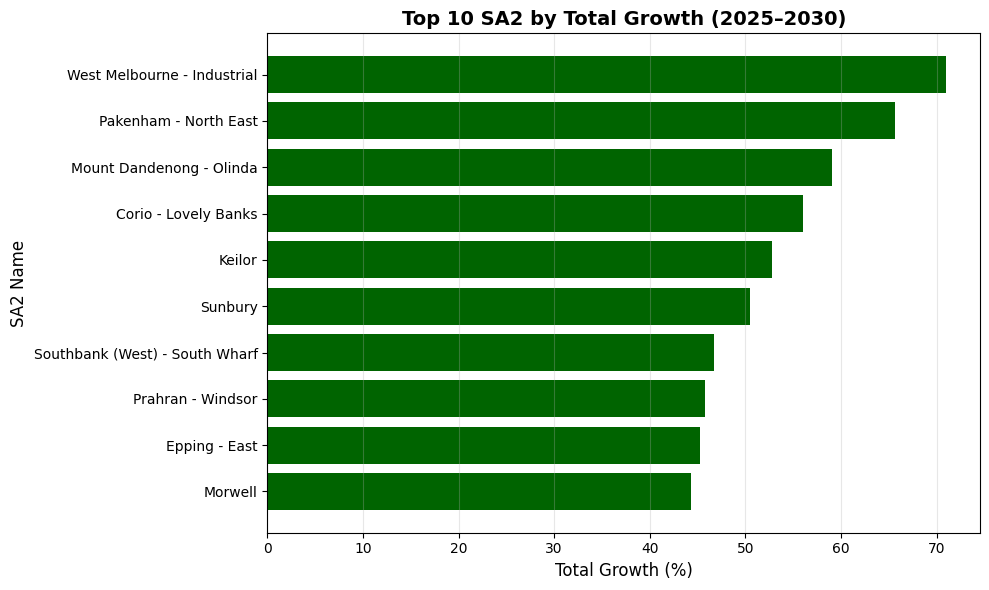

In [117]:
# Merge SA2_NAME21 into growth_results
growth_results = growth_results.merge(
    merged_df[["SA2_CODE21", "SA2_NAME21"]].drop_duplicates(),
    on="SA2_CODE21",
    how="left"
)

# Sort by Total_Growth_% descending, take top 10 and plot
top10_growth = growth_results.sort_values("Total_Growth_%", ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(
    y=top10_growth["SA2_NAME21"],
    width=top10_growth["Total_Growth_%"],
    color='darkgreen'
)

plt.gca().invert_yaxis()

plt.title("Top 10 SA2 by Total Growth (2025–2030)", fontsize=14, fontweight='bold')
plt.xlabel("Total Growth (%)", fontsize=12)
plt.ylabel("SA2 Name", fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


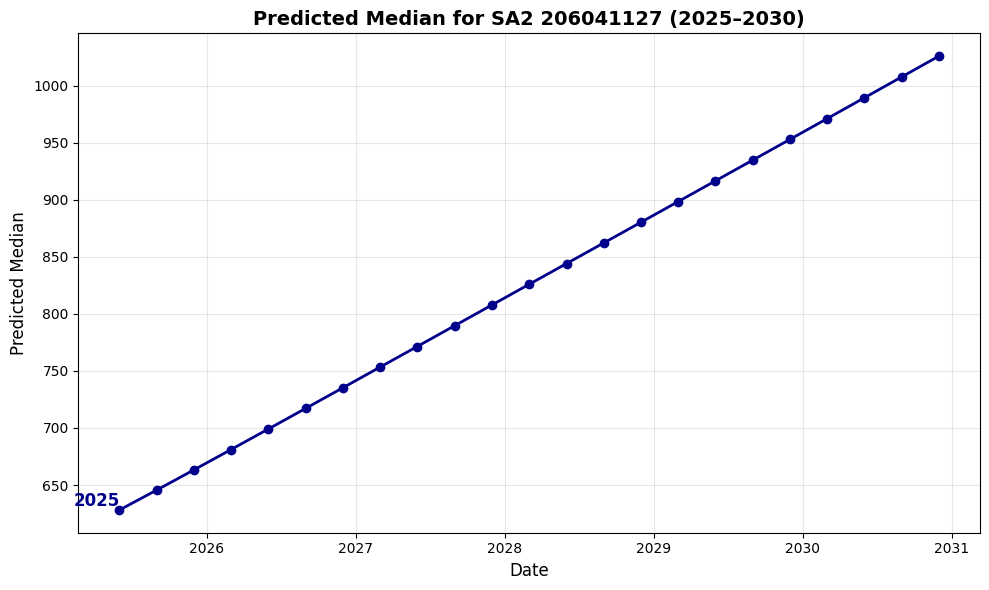

In [118]:
# Plot line chart for the SA2 that has the highest growth
sa2_target = 206041127
sa2_data = future_forecasts[future_forecasts["SA2_CODE21"] == sa2_target].copy()

#  Convert 'date' to datetime
sa2_data["date"] = pd.to_datetime(sa2_data["date"])

# Plot 
plt.figure(figsize=(10, 6))
plt.plot(
    sa2_data["date"],
    sa2_data["Predicted_Median"],
    marker='o',
    linestyle='-',
    color='darkblue',
    linewidth=2,
    markersize=6
)

start_value = sa2_data["Predicted_Median"].iloc[0]
start_date = sa2_data["date"].iloc[0]
plt.text(start_date, start_value, "2025", fontsize=12, fontweight='bold', color='darkblue', ha='right', va='bottom')

plt.title(f"Predicted Median for SA2 {sa2_target} (2025–2030)", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Predicted Median", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
